In [3]:
%matplotlib inline

'''
Basic exploration of Baltimore 311 service requests.

Some questions we could ask:

  - Can we detect local bursts of similar calls? And if so, can we alert neighborhood organizations that requests are 
    being submitted? E.g., if nearby houses in a neighborhood are all calling about a burst pipe, potholes, etc.,
    could we tweet, email neighborhood lists, post on Nextdoor.com, etc.?

  - Is the city more responsive to some neighborhoods than others? 
    - How often are requests not resolved? 
    - How long does it take for requests to be resolved?

  - What are the top complaints for each neighborhood?
  
  - How requests correlate with weather, time of year, etc.?
    - Low water pressure / leaks over time?
    - Can multiple localized reports of low water pressure predict imminent bursts? 
      - Better data sources to ask this question?

  - Is there a trend over time for phone vs. internet requests?

References:
https://data.baltimorecity.gov/City-Services/311-Customer-Service-Requests/9agw-sxsr
'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# replace with the full path to your local source data
SRC_FILE = '/Users/macarlin/data/311_Customer_Service_Requests.csv'

In [34]:
# load the source data
df = pd.read_csv(SRC_FILE)
df['CreatedDate'] = pd.to_datetime(df['CreatedDate'], format='%m/%d/%Y %I:%M:%S %p +0000')
df.set_index('CreatedDate', inplace=True)

In [35]:
# what are the headers of this csv?
list(df)

# how many rows?
df.shape

# what neighborhoods are represented?
neighborhoods = df['Neighborhood'].unique()

# what kinds of requests are we dealing with?
request_types = df['SRType'].unique()

print 'Found %s neighborhoods, %s request types' % (neighborhoods.shape[0], request_types.shape[0])
print sorted(neighborhoods)
print sorted(request_types)

Found 271 neighborhoods, 397 request types
['ABELL', 'ALLENDALE', 'ARCADIA', 'ARLINGTON', 'ARMISTEAD GARDENS', 'ASHBURTON', 'BALTIMORE HIGHLANDS', 'BALTIMORE-LINWOOD', 'BARCLAY', 'BARRE CIRCLE', 'BEECHFIELD', 'BELAIR-EDISON', 'BELAIR-PARKSIDE', 'BELLONA-GITTINGS', 'BEREA', 'BETTER WAVERLY', 'BEVERLY HILLS', 'BIDDLE STREET', 'BLYTHEWOOD', 'BOLTON HILL', 'BOOTH-BOYD', 'BREWERS HILL', 'BRIDGEVIEW/GREENLAWN', 'BROADWAY EAST', 'BROENING MANOR', 'BROOKLYN', 'BURLEITH-LEIGHTON', "BUTCHER'S HILL", 'CALLAWAY-GARRISON', 'CAMERON VILLAGE', 'CANTON', 'CANTON INDUSTRIAL AREA', 'CARROLL - CAMDEN INDUSTRIAL AREA', 'CARROLL PARK', 'CARROLL-SOUTH HILTON', 'CARROLLTON RIDGE', 'CEDARCROFT', 'CEDMONT', 'CEDONIA', 'CENTRAL FOREST PARK', 'CENTRAL PARK HEIGHTS', 'CHARLES NORTH', 'CHARLES VILLAGE', 'CHERRY HILL', 'CHESWOLDE', 'CHINQUAPIN PARK-BELVEDERE', 'CHRISTOPHER', 'CLAREMONT-FREEDOM', 'CLIFTON PARK', 'COLDSPRING', 'COLDSTREAM HOMESTEAD MONTEBELLO', 'CONCERNED CITIZENS OF FOREST PARK', 'COPPIN HEIGHTS/ASH

Text(0,0.5,'Count')

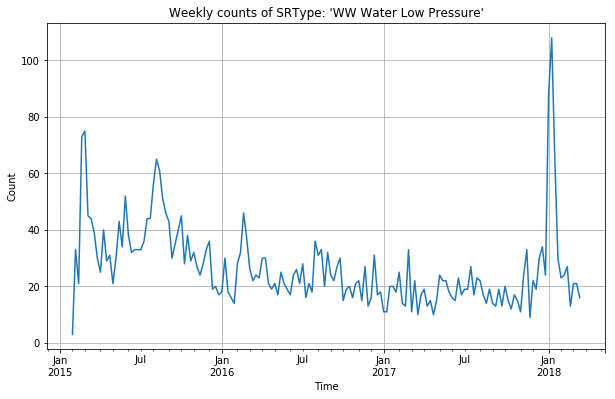

In [76]:
# visualize some activity over time for a specific category, binned by week
CATEGORY = 'WW Water Low Pressure'#'WW Water Leak (Exterior)'#'WW Hydrant Open'
gb = df.groupby('SRType')
gb_exterior_leaks = gb.get_group(CATEGORY).resample('W').count()

ax = gb_exterior_leaks['SRType'].plot(title='Weekly counts of SRType: \'%s\'' % CATEGORY,
                                     figsize=(10, 6),
                                     grid=True)
ax.set_xlabel('Time')
ax.set_ylabel('Count')